In [1]:
!pip --quiet install pytorch-warmup

In [2]:
from IPython.display import clear_output 
!pip --quiet install pytorch_spiking pytorch_lightning #pytorch_forecasting 
clear_output()

In [3]:
import os
import time
import sys

import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import pickle

import torch
import torch.nn as nn
from torch.nn.modules import TransformerEncoder, TransformerEncoderLayer, LayerNorm
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import pytorch_spiking
import pytorch_warmup as warmup

import matplotlib.pyplot as plt

In [4]:
config = {
  "plots": {
        "show_plots": False,
        "xticks_interval": 1200,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_test": "#FF4136",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "data": {
        "train_split_size": 0.80,
        "input_window": 150,
        "output_window": 50,
        "train_batch_size": 32,
        "eval_batch_size": 1,
        "scaler": "normal"
    }, 
    "model_transformer": {
        "feature_size": 250,
        "nhead": 10,
        "num_layers": 2,
        "dropout": 0.2,
        "out_features": 1,
        "init_range": 2, #0.5
        "lr": 0.0002, #0.0001,
        "loss": "dilate"
    },
    "paths": {
        "drive": {
            "agg_trade": {
                "train": "/content/drive/MyDrive/IP/Repos/HFTransformer/input_data/",
                "test": "/content/drive/MyDrive/IP/Repos/HFTransformer/input_data/", 
            },
            "orderbook": {
                "train": "/content/drive/MyDrive/IP/Repos/HFTransformer/input_data/",
                "test": "/content/drive/MyDrive/IP/Repos/HFTransformer/input_data/",
            },
            "models": "/content/drive/MyDrive/IP/Repos/HFTransformer/models/",
            "figures": "/content/drive/MyDrive/IP/Repos/HFTransformer/figures/",
            "utils": "/content/drive/MyDrive/IP/Repos/HFTransformer/utils/",
        },
        "local": {
            "agg_trade": {
                "train": "./input_data/",
                "test": "./input_data/", 
            },
            "orderbook": {
                "train": "./input_data/",
                "test": "./input_data/",
            },
            "models": "./models/",
            "figures": "./figures/",
        }
    }
}

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
drive = True

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data preparation: normalizing raw financial data

In [7]:
def augment_trade_data(df, lag, forecast_window=None):
    if forecast_window:
        df['lag_return'] = np.log(df['price'].shift(forecast_window)/df['price'].shift(forecast_window+1))
        return df.iloc[forecast_window+1:,:]
    if lag == 0:
        return df
    else:
        col_name = 'log_lag'+str(lag)+'_price'
        df[col_name] = np.log(df.price) - np.log(df.price).shift(lag)
        return df.iloc[lag:,:]

def normalize_train_test(df_train, df_test, features):
    train_data = df_train[features]
    test_data = df_test[features]
    return train_data, test_data

## Defining Transformer Model

In [37]:
class HFformer(nn.Module):
    def __init__(self, n_time_series, seq_len, output_seq_len, d_model=128,
                 n_heads=8, n_layers_encoder=6, dropout=0.1, output_dim=1, forward_dim=2048,
                 use_mask=False, quantiles=None):
        """Uses a number of encoder layers with simple linear decoder layer.
        """
        super(HFformer, self).__init__()
        self.n_time_series = n_time_series
        self.d_model = d_model
        self.nheads = n_heads
        self.forward_dim = forward_dim
        self.dropout = dropout
        self.n_layers_encoder = n_layers_encoder
        self.seq_len = seq_len
        self.output_seq_len = output_seq_len
        self.mask_it = use_mask
        self.quantiles = quantiles
        self.output_dim = output_dim 

        self.dense_shape = nn.Linear(self.n_time_series, self.d_model)
        self.encoder_layer = TransformerEncoderLayer(self.d_model, self.nheads, self.forward_dim, self.dropout,
                                                     activation=pytorch_spiking.SpikingActivation(nn.PReLU()))
        self.encoder_norm = LayerNorm(self.d_model)
        self.transformer_enc = TransformerEncoder(self.encoder_layer, self.n_layers_encoder, self.encoder_norm)
        self.output_dim_layer = nn.Linear(self.d_model, self.output_dim)
        # self.output_dim_layer = nn.LSTM(self.d_model, self.output_dim, 1, batch_first=False)
        if quantiles:
            self.out_length_lay = nn.Linear(self.seq_len, len(quantiles))#, 1, batch_first=True)
        else:
            self.out_length_lay = nn.Linear(self.seq_len, self.output_seq_len)#, 1, batch_first=True)
        self.mask = generate_square_subsequent_mask(self.seq_len).to(device)
        self.activation = nn.PReLU() #pytorch_spiking.SpikingActivation(nn.PReLU().to('cuda')).to('cuda')


    def make_embedding(self, x):
        x = self.dense_shape(x)
        x = x.permute(1, 0, 2)
        if self.mask_it:
            x = self.transformer_enc(x, self.mask)
        else:
            x = self.transformer_enc(x)
        return x


    def forward(self, x):
        x = self.dense_shape(x)
        x = x.permute(1, 0, 2)
        if self.mask_it:
            x = self.transformer_enc(x, self.mask)
        else:
            x = self.transformer_enc(x)
        x = self.output_dim_layer(x)
        x = x.permute(1, 2, 0)
        x = self.activation(x)
        x = self.out_length_lay(x)
        if self.output_dim > 1:
            return x.permute(0, 2, 1)
        if self.quantiles:
            return x.view(-1, len(self.quantiles))
        else:
            return x.view(-1, self.output_seq_len)


def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

## Defining Loader

In [9]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])


def prepare_data_x(data, window_size, lag):
    # perform windowing
    n_row = data.shape[0] - window_size + 1
    subset = data[:window_size]
    subset_mean = np.mean(subset, axis=0)
    output = np.zeros([n_row, window_size, len(subset_mean)])
    x_mean = np.zeros([n_row, len(subset_mean)])
    x_std = np.zeros([n_row, len(subset_mean)])
    for idx in range(n_row):
        subset = data[idx:idx+window_size]
        subset_mean = np.mean(subset, axis=0)
        subset_std = np.std(subset, axis=0) + 0.01
        subset_norm = (subset-subset_mean)/subset_std
        x_mean[idx,:] = subset_mean
        x_std[idx,:] = subset_std
        output[idx,:,:] = subset_norm
    # output = np.array(output)
    x_mean = np.array(x_mean)
    x_std = np.array(x_std)
    return output[:-lag-1], output[-1], x_mean, x_std

def prepare_data_y(x, window_size, lag):
    output = np.zeros([len(x)-window_size-lag])
    std = 1.1*np.sqrt(lag)+lag*0.01
    for idx in range(0,len(x)-window_size-lag):
        output[idx] = np.log(x[window_size+lag-1+idx,0]/x[window_size-1+idx,0])*10_000
    output = output/std
    return output

def prepare_data(normalized_prices_train, dates_train, normalized_prices_test, dates_test, config, lag=1, plot=False):
    data_x, data_x_unseen, x_mean, x_std = prepare_data_x(normalized_prices_train, window_size=100, lag=lag)
    data_y = prepare_data_y(normalized_prices_train, window_size=100, lag=lag)
    
    # split dataset
    split_index = int(data_y.shape[0]*0.8)
    data_x_train = data_x[:split_index]
    data_x_val = data_x[split_index:]
    data_y_train = data_y[:split_index]
    data_y_val = data_y[split_index:]

    return split_index, data_x_train, data_y_train, data_x_val, data_y_val

## Defining Custom Losses

In [10]:
def quantile_loss(y, y_pred, quantile):
  """Computes quantile loss for tensorflow.

  Standard quantile loss as defined in the "Training Procedure" section of
  the main TFT paper

  Args:
    y: Targets
    y_pred: Predictions
    quantile: Quantile to use for loss calculations (between 0 & 1)

  Returns:
    Tensor for quantile loss.
  """
  if quantile < 0 or quantile > 1:
    raise ValueError(
        'Illegal quantile value={}! Values should be between 0 and 1.'.format(
            quantile))

  prediction_underflow = y - y_pred
  q_loss = quantile * torch.max(prediction_underflow, torch.zeros_like(prediction_underflow)) + (
      1. - quantile) * torch.max(-prediction_underflow, torch.zeros_like(prediction_underflow))

  return torch.sum(q_loss, axis=-1)

## Defining Helper Functions

In [43]:
criterion_dict = {"MAE":nn.L1Loss, "MSE":nn.MSELoss, "QuantileLoss":quantile_loss}

def compute_loss(labels, output, src, criterion, quantiles):
    """Function for computing the loss
    """
    if isinstance(output, torch.Tensor):
        if len(labels.shape) != len(output.shape):
            if len(labels.shape) > 1:
                if labels.shape[1] == output.shape[1]:
                    labels = labels.unsqueeze(2)
                else:
                    labels = labels.unsqueeze(0)
    loss = 0
    if quantiles:
        for idx, quantile in enumerate(quantiles):
            loss += criterion(output[:,idx], labels.float(), quantile)
    else:
        loss = criterion(output, labels.float())
    return loss


def train_step(model, opt, criterion, data_loader, takes_target, device,
                       num_targets=1, forward_params={}):
    """Function that performs training of a single model. Runs through one epoch of the data.
    """
    i = 0
    running_loss = 0.0
    model.train()
    for src, trg in data_loader:
        opt.zero_grad()
        if takes_target:
            forward_params["t"] = trg.to(device)
        src = src.to(device)
        trg = trg.to(device)
        output = model(src, **forward_params)
        output = output.squeeze()
        if num_targets == 1:
            labels = trg
        elif num_targets > 1:
            labels = trg[:, :, 0:num_targets]
        loss = compute_loss(labels, output, src, criterion[0], quantiles=model.quantiles)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        i += 1
    total_loss = running_loss
    return total_loss


def validation(val_loader, model, criterion, device, num_targets=1):
    """Function to compute the validation loss metrics
    """
    crit_losses = dict.fromkeys(criterion, 0)
    model.eval()
    labels = torch.Tensor(0).to(device)
    labels_all = torch.Tensor(0).to(device)
    output_all = torch.Tensor(0).to(device)
    with torch.no_grad():
        for src, targ in val_loader:
            output = torch.Tensor(0).to(device)
            src = src if isinstance(src, list) else src.to(device)
            targ = targ if isinstance(targ, list) else targ.to(device)
            output = model(src.float())
            output = output.squeeze()
            output_all = torch.cat((output_all, output))
            if num_targets == 1:
                labels = targ
            elif num_targets > 1:
                labels = targ[:, :, 0:num_targets]
            for crit in criterion:
                loss = compute_loss(labels, output, src, crit, model.quantiles)
                crit_losses[crit] += loss.item()
            labels_all = torch.cat((labels_all, labels))
    return list(crit_losses.values())[0], output_all, labels_all

def forecast(data_loader, model, criterion, forecast_horizon, device, num_targets=1):
    crit_losses = dict.fromkeys(criterion, 0)
    model.eval()
    output_decoder = torch.Tensor(0).to(device)
    labels = torch.Tensor(0).to(device)
    labels_all = torch.Tensor(0).to(device)
    counter = 0
    with torch.no_grad():
        for src, targ in data_loader:
            if (counter % forecast_horizon) == 0:
                src = src if isinstance(src, list) else src.to(device)
                targ = targ if isinstance(targ, list) else targ.to(device)
                output = model(src.float())
                #output = output.reshape(1,-1)
                output_decoder = torch.cat((output_decoder, output))
                if num_targets == 1:
                    labels = targ
                elif num_targets > 1:
                    labels = targ[:, :, 0:num_targets]
                for crit in criterion:
                    loss = compute_loss(labels, output, src, crit, model.quantiles)
                    crit_losses[crit] += loss.item()
                labels_all = torch.cat((labels_all, labels))
            counter += 1
    return list(crit_losses.values())[0], output_decoder, labels_all

## Defining Trainer

In [12]:
def strategy_evaluator(true, pred):
    total_buys, total_sells, total_holds = np.sum(true>0), np.sum(true<0), np.sum(true==0)
    total_correct_buys, total_correct_sells, total_correct_holds = 0, 0, 0
    for idx in range(len(true)):
        for jdx in range(len(true[0])):
            if true[idx,jdx] > 0 and pred[idx,jdx] > 0:
                total_correct_buys += 1
            elif true[idx,jdx] < 0 and pred[idx,jdx] < 0:
                total_correct_sells += 1
            elif true[idx,jdx] == 0 and pred[idx,jdx] == 0:
                total_correct_holds += 1
    total_correct_buys_r, total_correct_sells_r, total_correct_holds_r = (total_correct_buys/total_buys),(total_correct_sells/total_sells),(total_correct_holds/total_holds)
    return total_correct_buys_r.round(3), total_correct_sells_r.round(3), total_correct_holds_r.round(3)

In [45]:
def trainer(model, train_loader, validation_loader, test_loader, criterion, opt, scheduler, warmup_scheduler, max_epochs, batch_size, forecast_horizon,
            takes_target, shuffle=False, num_targets=1, plot_prediction=True, save_path=None, LAG=0):
    start_time = time.time()
    
    data_loader = DataLoader(train_loader, batch_size=batch_size, shuffle=shuffle, sampler=None, batch_sampler=None, num_workers=10)
    validation_data_loader = DataLoader(validation_loader, batch_size=batch_size, shuffle=False, sampler=None, batch_sampler=None, num_workers=10)
    test_data_loader = DataLoader(test_loader, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=2)
    forecast_data_loader = DataLoader(validation_loader, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=2)
    
    for epoch in range(1, max_epochs+1):
        total_loss = train_step(model, opt, criterion, data_loader, takes_target, device, num_targets=num_targets)
        val_loss = 0
        if plot_prediction:
            val_loss, val_values, true_values = forecast(forecast_data_loader, model, criterion, forecast_horizon=forecast_horizon,
                                                                   device=device, num_targets=num_targets)
            fig, ax = plt.subplots(1, 1, figsize = (18, 8))
            ax.plot(true_values.cpu().view(-1), label='truth', alpha=0.3)
            ax.plot(val_values.cpu().view(-1), label='forecast', alpha=0.8)
            ax.set_xlim(left=0, right=len(true_values.cpu().view(-1)))
            plt.show()
        else:
            val_loss, val_values, true_values = validation(validation_data_loader, model, criterion, device,
                                                            num_targets=num_targets)
            # val_loss, val_values, true_values, src_all
        preds, trues = val_values.cpu().numpy(), true_values.cpu().numpy()#, src_all.cpu().numpy()

        print(f'preds {preds.shape}')
        print(f'trues {trues.shape}')

        results = 0
        if model.quantiles:
            r2_sklearn = r2_score(trues, preds[:,len(model.quantiles)//2])
        else:
            r2_sklearn = r2_score(trues, preds)

        elapsed = time.time() - start_time
        print('-' * 88)
        print('| epoch {:3d} | {:5.2f} s | train loss {:5.5f} | val loss {:5.5f} | lr {:1.8f} | r2 sklearn: {:1.5f} | b, s, h: {:}|'.format(
                        epoch, elapsed, total_loss, val_loss, scheduler.get_last_lr()[0], r2_sklearn, results))
        print('-' * 88)
        start_time = time.time()

        if save_path:
            results = {
                    'model': 'HFformer',
                    'pred_len': forecast_horizon,
                    'epoch': epoch,
                    'train_loss': total_loss,
                    'val_loss': val_loss,
                    'r2_val_sklearn': r2_sklearn            
            }

            df = pd.DataFrame([results])
            df.to_csv(save_path, mode='a', header=not os.path.exists(save_path), index=False)

        with warmup_scheduler.dampening():
            scheduler.step()


## Model and Training

In [14]:
date_train = 'all' 
date_test = 'all'

if drive:
    agg_trade = pd.read_csv(config["paths"]["drive"]["agg_trade"]["train"]+date_train+'/orderbook.csv')
    
    sys.path.append(config["paths"]["drive"]["utils"])
else:
    agg_trade = pd.read_csv(config["paths"]["local"]["agg_trade"]["train"]+date_train+'/orderbook.csv')
    agg_trade_test = pd.read_csv(config["paths"]["local"]["agg_trade"]["test"]+date_test+'/orderbook.csv')

In [15]:
agg_trade['price'] = agg_trade['w_midprice']
agg_trade = agg_trade[agg_trade['update_diff']>0]

In [16]:
forecast_history = 100 #100
forecast_window = 30
epochs = 30
batch_size = 128 #64

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


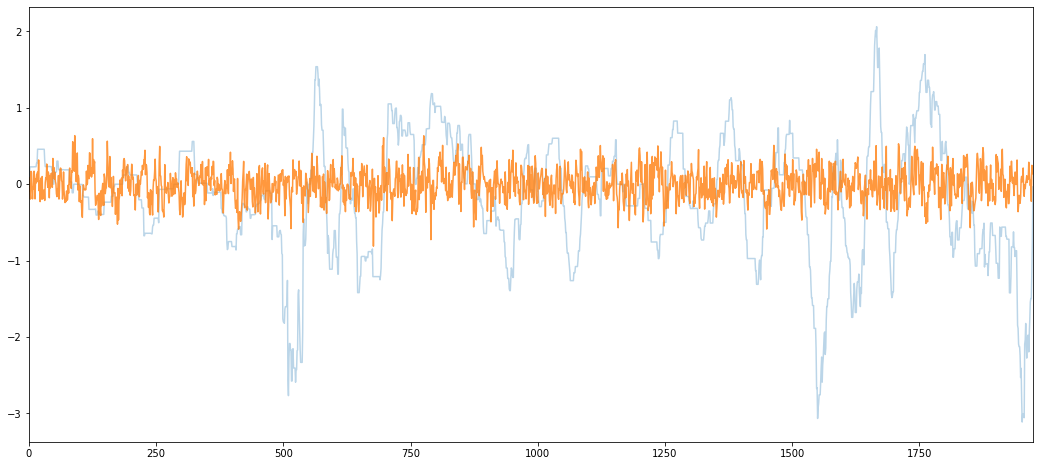

preds (1974, 1)
trues (1974,)
----------------------------------------------------------------------------------------
| epoch   1 |  9.10 s | train loss 967.20518 | val loss 1351.07595 | lr 0.00010000 | r2 sklearn: -0.12584 | b, s, h: 0|
----------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


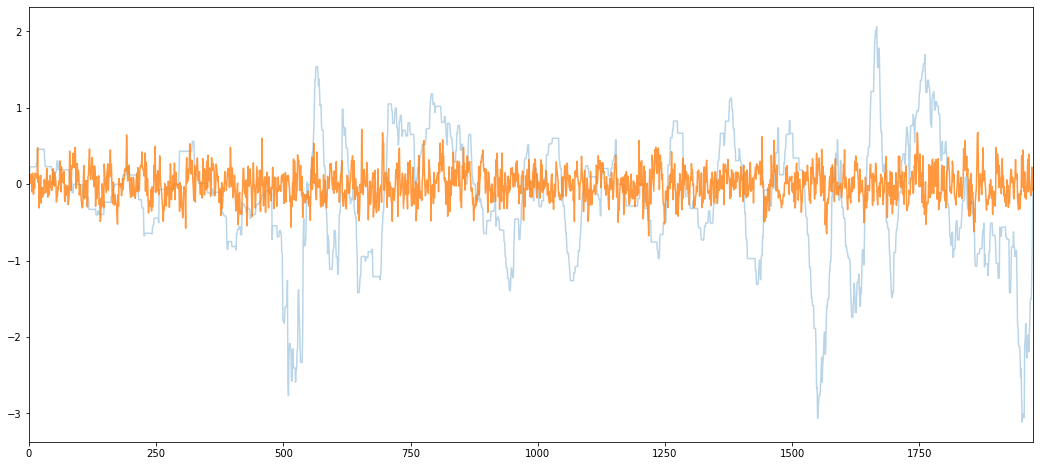

preds (1974, 1)
trues (1974,)
----------------------------------------------------------------------------------------
| epoch   2 |  9.55 s | train loss 959.42656 | val loss 1340.28863 | lr 0.00009950 | r2 sklearn: -0.11685 | b, s, h: 0|
----------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: ignored

In [47]:
features = ['price', 'lag_return',
            'bid1', 'bidqty1', 'bid2', 'bidqty2', 'bid3', 'bidqty3', 'bid4', 'bidqty4', 'bid5', 'bidqty5',
            'bid6', 'bidqty6', 'bid7', 'bidqty7', 'bid8', 'bidqty8', 'bid9', 'bidqty9',
            'ask1', 'askqty1', 'ask2', 'askqty2', 'ask3', 'askqty3', 'ask4', 'askqty4', 'ask5', 'askqty5',
            'ask6', 'askqty6', 'ask7', 'askqty7', 'ask8', 'askqty8', 'ask9', 'askqty9']

model_custom = HFformer(n_time_series=len(features), seq_len=forecast_history, output_seq_len=1, d_model=80,
                 n_heads=2, n_layers_encoder=1, dropout=0.2, output_dim=1, forward_dim=512, use_mask=True#, quantiles=[0.1,0.5,0.9]
                 ).to(device)

criterion = nn.MSELoss(reduction='sum')
# criterion = quantile_loss
optimizer = optim.AdamW(model_custom.parameters(), lr=0.0001, amsgrad=True) #0.00005 
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period=1000)


orderbook = augment_trade_data(agg_trade, lag=0, forecast_window=forecast_window)


split_index, data_x_train, data_y_train, data_x_val, data_y_val = prepare_data(np.array(orderbook[features][1_000_000:1_010_000]),
                                                                                np.array(agg_trade.datetime[1_000_000:1_100_000]),
                                                                                np.array(orderbook[features][2_060_000:2_060_600]),
                                                                                np.array(agg_trade.datetime[2_060_000:2_060_600]),
                                                                                config, lag=forecast_window, plot=False)


train_loader = TimeSeriesDataset(data_x_train, data_y_train)
val_loader = TimeSeriesDataset(data_x_val, data_y_val)
test_loader = None


trainer(model_custom, train_loader, val_loader, test_loader, [criterion], optimizer, scheduler, warmup_scheduler, epochs, batch_size,
        forecast_horizon=1, takes_target=False, plot_prediction=True)

## Optimal paramater search

In [ ]:
date_train = 'all' 
date_test = 'all'

if drive:
    agg_trade = pd.read_csv(config["paths"]["drive"]["agg_trade"]["train"]+date_train+'/orderbook.csv')    
    sys.path.append(config["paths"]["drive"]["utils"])
else:
    agg_trade = pd.read_csv(config["paths"]["local"]["agg_trade"]["train"]+date_train+'/orderbook_agg_trade_dollarvol.csv')
    agg_trade_test = pd.read_csv(config["paths"]["local"]["agg_trade"]["test"]+date_test+'/orderbook_agg_trade_dollarvol.csv')

agg_trade['price'] = agg_trade['w_midprice']
agg_trade_test = agg_trade[4_500_000:]

In [ ]:
save_path = os.path.join('/content/drive/MyDrive/IP/Repos/HFTransformer/results_HFformer',
                            str(int(time.time()))+'_results.csv')
# save_path=None

forecast_history = 100 
epochs = 16
batch_size = 256 #64 for linear decoder

forecast_windows = [i for i in range(1,31)]

for forecast_window in forecast_windows:
    
    orderbook = augment_trade_data(agg_trade, lag=0, forecast_window=forecast_window)

    features = ['price', 'lag_return',
                'bid1', 'bidqty1', 'bid2', 'bidqty2', 'bid3', 'bidqty3', 'bid4', 'bidqty4', 'bid5', 'bidqty5',
                'bid6', 'bidqty6', 'bid7', 'bidqty7', 'bid8', 'bidqty8', 'bid9', 'bidqty9',
                'ask1', 'askqty1', 'ask2', 'askqty2', 'ask3', 'askqty3', 'ask4', 'askqty4', 'ask5', 'askqty5',
                'ask6', 'askqty6', 'ask7', 'askqty7', 'ask8', 'askqty8', 'ask9', 'askqty9']

    split_index, data_x_train, data_y_train, data_x_val, data_y_val = prepare_data(np.array(orderbook[features][1_000_000:1_720_000]),
                                                                                                                            np.array(agg_trade.datetime[2_005_000:2_006_000]),
                                                                                                                            np.array(orderbook[features][60_000:60_600]),
                                                                                                                            np.array(agg_trade.datetime[60_000:60_600]),
                                                                                                                            config, lag=forecast_window, plot=False)


    train_loader = TimeSeriesDataset(data_x_train, data_y_train)
    val_loader = TimeSeriesDataset(data_x_val, data_y_val)
    test_loader = None

    model_custom = HFformer(n_time_series=len(features), seq_len=forecast_history, output_seq_len=1, d_model=36,
                  n_heads=6, n_layers_encoder=2, dropout=0.3, output_dim=1, forward_dim=64, use_mask=True).to(device)

    criterion = nn.MSELoss(reduction='sum')
    optimizer = optim.AdamW(model_custom.parameters(), lr=0.1, amsgrad=True)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
    warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period=1000)

    trainer(model_custom, train_loader, val_loader, test_loader, [criterion], optimizer, scheduler, warmup_scheduler, epochs, batch_size=batch_size,
        forecast_horizon=forecast_window, takes_target=False, plot_prediction=False, save_path=save_path, LAG=forecast_window)
    
    del data_x_train 
    del data_y_train
    del data_x_val
    del data_y_val

    torch.save(model_custom, f'/content/drive/MyDrive/IP/Repos/HFTransformer/models/transformer_enclinear_forecasting_FINAL_horizon_{forecast_window}.pt')
    print(f'Done with prediction len {forecast_window}.')

## Forecast Evaluator

In [ ]:
def strategy_evaluator(true, pred, weighted=False):
    total_buys, total_sells, total_holds = np.sum(true>0), np.sum(true<0), np.sum(true==0)
    total_correct_buys, total_correct_sells, total_correct_holds = 0, 0, 0
    for idx in range(len(true)):
        if true[idx] > 0 and pred[idx] > 0:
            total_correct_buys += 1
        elif true[idx] < 0 and pred[idx] < 0:
            total_correct_sells += 1
        elif true[idx] == 0 and pred[idx] == 0:
            total_correct_holds += 1
    total_correct_buys_r, total_correct_sells_r, total_correct_holds_r = (total_correct_buys/total_buys),(total_correct_sells/total_sells),(total_correct_holds/total_holds)
    total_correct_trades = (total_correct_buys+total_correct_sells+total_correct_holds)/(total_buys+total_sells+total_holds)
    return total_buys, total_correct_buys, total_sells, total_correct_sells, total_holds, total_correct_holds

def pnl_evaluator(true, pred, src, fee=0):
    total_pnl = 0
    total_buys, total_sells, total_holds = np.sum(true>0), np.sum(true<0), np.sum(true==0)
    total_correct_buys, total_correct_sells, total_correct_holds = 0, 0, 0
    for idx in range(len(true)):
        if true[idx] > 0 and pred[idx] > 0:
            total_correct_buys += 1
        elif true[idx] < 0 and pred[idx] < 0:
            total_correct_sells += 1
        elif true[idx] == 0 and pred[idx] == 0:
            total_correct_holds += 1
    total_correct_buys_r, total_correct_sells_r, total_correct_holds_r = (total_correct_buys/total_buys),(total_correct_sells/total_sells),(total_correct_holds/total_holds)
    total_correct_trades = (total_correct_buys+total_correct_sells+total_correct_holds)/(total_buys+total_sells+total_holds)
    return total_buys, total_correct_buys, total_sells, total_correct_sells, total_holds, total_correct_holds

def forecast_evaluator(test_loader, model, criterion, forecast_horizon=1, device=device, num_targets=1, save_path=None):
    test_data_loader = DataLoader(test_loader, batch_size=128, shuffle=False, sampler=None, batch_sampler=None, num_workers=6)
    loss, pred, true = forecast(test_data_loader, model, criterion, forecast_horizon=1, device=device, num_targets=1)
    pred, true = pred.cpu().numpy(), true.cpu().numpy()

    r2 = r2_score(true, pred)
    strategy_results = strategy_evaluator(true, pred)

    if save_path:
        results = {
                'model': 'HFformer',
                'pred_len': forecast_horizon,
                'test_loss': loss,
                'r2_val_sklearn': r2,
                'correct_buys': strategy_results[1],
                'total_buys':  strategy_results[0],
                'correct_sells': strategy_results[3],
                'total_sells': strategy_results[2],
                'correct_holds': strategy_results[5],
                'total_holds': strategy_results[4],
        }

        df = pd.DataFrame([results])
        df.to_csv(save_path, mode='a', header=not os.path.exists(save_path), index=False)

    print(f'| test loss {loss} | b, cb, s, cs, h, ch: {strategy_results} |')

    return pred, true


## Forecasting

In [ ]:
date_train = 'all' 
date_test = 'all'

if drive:
    agg_trade = pd.read_csv(config["paths"]["drive"]["agg_trade"]["train"]+date_train+'/orderbook.csv')    
    sys.path.append(config["paths"]["drive"]["utils"])
else:
    agg_trade = pd.read_csv(config["paths"]["local"]["agg_trade"]["train"]+date_train+'/orderbook_agg_trade_dollarvol.csv')
    agg_trade_test = pd.read_csv(config["paths"]["local"]["agg_trade"]["test"]+date_test+'/orderbook_agg_trade_dollarvol.csv')

agg_trade['price'] = agg_trade['w_midprice']
agg_trade_test = agg_trade[4_500_000:]

In [ ]:
save_path = os.path.join('/content/drive/MyDrive/IP/Repos/HFTransformer/results_HFformer',
                            str(int(time.time()))+'_forecasting_results.csv')

# save_path = None

save_path_results = os.path.join('/content/drive/MyDrive/IP/Repos/HFTransformer/results_HFformer',
                            str(int(time.time()))+'_list_results.pkl')

forecast_history = 100 
batch_size = 256 #64 for linear decoder

forecast_windows = [i for i in range(1,31)]

predictions = []

for forecast_window in forecast_windows:
    
    orderbook = augment_trade_data(agg_trade, lag=0, forecast_window=forecast_window)

    features = ['price', 'lag_return',
                'bid1', 'bidqty1', 'bid2', 'bidqty2', 'bid3', 'bidqty3', 'bid4', 'bidqty4', 'bid5', 'bidqty5',
                'bid6', 'bidqty6', 'bid7', 'bidqty7', 'bid8', 'bidqty8', 'bid9', 'bidqty9',
                'ask1', 'askqty1', 'ask2', 'askqty2', 'ask3', 'askqty3', 'ask4', 'askqty4', 'ask5', 'askqty5',
                'ask6', 'askqty6', 'ask7', 'askqty7', 'ask8', 'askqty8', 'ask9', 'askqty9']

    split_index, data_x_train, data_y_train, data_x_val, data_y_val = prepare_data(np.array(orderbook[features][2_800_000:3_050_000]),
                                                                                    np.array(agg_trade.datetime[2_005_000:2_006_000]),
                                                                                    np.array(orderbook[features][60_000:60_600]),
                                                                                    np.array(agg_trade.datetime[60_000:60_600]),
                                                                                    config, lag=forecast_window, plot=False)

    test_loader = TimeSeriesDataset(data_x_train, data_y_train)

    model = torch.load(f'/content/drive/MyDrive/IP/Repos/HFTransformer/models/transformer_enclinear_forecasting_FINAL_horizon_{forecast_window}.pt')
    criterion = nn.MSELoss(reduction='sum')

    pred, true = forecast_evaluator(test_loader, model, [criterion], forecast_horizon=1, device=device, num_targets=1, save_path=save_path)
    
    predictions.append((pred, true))
    
    # del data_x_train 
    # del data_y_train
    # del data_x_val
    # del data_y_val

    print(f'Done with prediction len {forecast_window}.')

with open(save_path_results, 'wb') as f:
    pickle.dump(predictions, f)